# Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning

*Authors: Eléa VELLARD, Enzo CHAROLOIS*  
*Date: 01/05/2025*


# Overview
In this notebook, we reproduce results from the paper **"Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"** by Gal & Ghahramani (2016). We will:
1. Visualize MC Dropout uncertainty distribution over samples in a regression task;
2. Perform MC Dropout uncertainty estimate on a regression task;
3. Perform MC Dropout uncertainty estimate on a classification task;
4. Visualize how MC Dropout can help improve exploration in a Reinforcement Learning task.


# Environment Setup
Install required packages if not already installed:


In [ ]:
# %pip install torch torchvision numpy matplotlib

In [ ]:
# !pip install sympy --upgrade --force-reinstall

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import torchvision
import math
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from collections import deque
import torch.optim as optim
import random
from tqdm.notebook import tqdm
import pandas as pd

## Experiment 1: MC Dropout for Regression and Uncertainty Visualization

The goal of this experiment is to apply MC Dropout to a regression task using the California Housing dataset in order to visualize predictive uncertainty. By performing multiple stochastic forward passes at test time, we estimate both the predicted house prices and their uncertainty, demonstrating how MC Dropout captures the model’s confidence in its predictions.

We start by defining a neural network for regression with MC Dropout.
It consists of two hidden layers with ReLU activations and dropout applied after each, followed by a final linear layer that outputs a single value.
Dropout remains **active during inference** to enable uncertainty estimation via MC sampling.

In [ ]:
class MCDropoutRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Output = scalar (régression)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


The following function performs MC Dropout inference.
It runs T stochastic forward passes with dropout active to collect predictions, then returns the mean and standard deviation across those predictions, representing the model’s prediction and its uncertainty.

In [ ]:
def predict_mc(model, X, T=100):
    """
    Perform T stochastic forward passes with dropout active,
    return mean and std of the outputs.
    """
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(T):
            preds.append(model(X).cpu().numpy())
    arr = np.stack(preds)
    return arr.mean(0), arr.std(0)


We load the dataset, standardize the features and target, and split it into training and test sets.


In [ ]:
# Load the data
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)

# Standardize input and output
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

Then, we apply MC Dropout to the California Housing dataset. After preprocessing, a two-layer neural network with dropout (0.1) is trained for 2,000 epochs. At test time, 100 stochastic forward passes yield predictive means and uncertainties. We compute RMSE and visualize predictions with ±2σ bands to demonstrate MC Dropout's ability to quantify regression uncertainty.

Then, we initialize the MC Dropout regression model, the optimizer and the loss function.


In [ ]:
model = MCDropoutRegressor(input_dim=X.shape[1], hidden_dim=100, dropout_rate=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)
loss_fn = nn.MSELoss()

The neural network is then trained for 2,000 epochs. At test time, we perform multiple stochastic forward passes to estimate both the mean and uncertainty of predictions. We compute RMSE and visualize predictions with ±2σ bands to demonstrate MC Dropout's ability to quantify regression uncertainty.

In [ ]:
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"[Epoch {epoch}] Loss = {loss.item():.4f}")

#Predict with MC Dropout
mean_preds, std_preds = predict_mc(model, X_test, T=100)

mean_preds = scaler_y.inverse_transform(mean_preds)
true_vals = scaler_y.inverse_transform(y_test)
std_preds = std_preds * scaler_y.scale_

mse = mean_squared_error(true_vals.ravel(), mean_preds.ravel())
rmse = np.sqrt(mse)
print(f"RMSE (MC Dropout) = {rmse:.2f}")

[Epoch 0] Loss = 0.9973
[Epoch 200] Loss = 0.2589
[Epoch 400] Loss = 0.2567
[Epoch 600] Loss = 0.2553
[Epoch 800] Loss = 0.2542
[Epoch 1000] Loss = 0.2550
[Epoch 1200] Loss = 0.2536
[Epoch 1400] Loss = 0.2529
[Epoch 1600] Loss = 0.2520
[Epoch 1800] Loss = 0.2561
RMSE (MC Dropout) = 0.58


For the first plot, we show the predicted house prices with ±2σ uncertainty band, to visualize how confident the model is across test points.

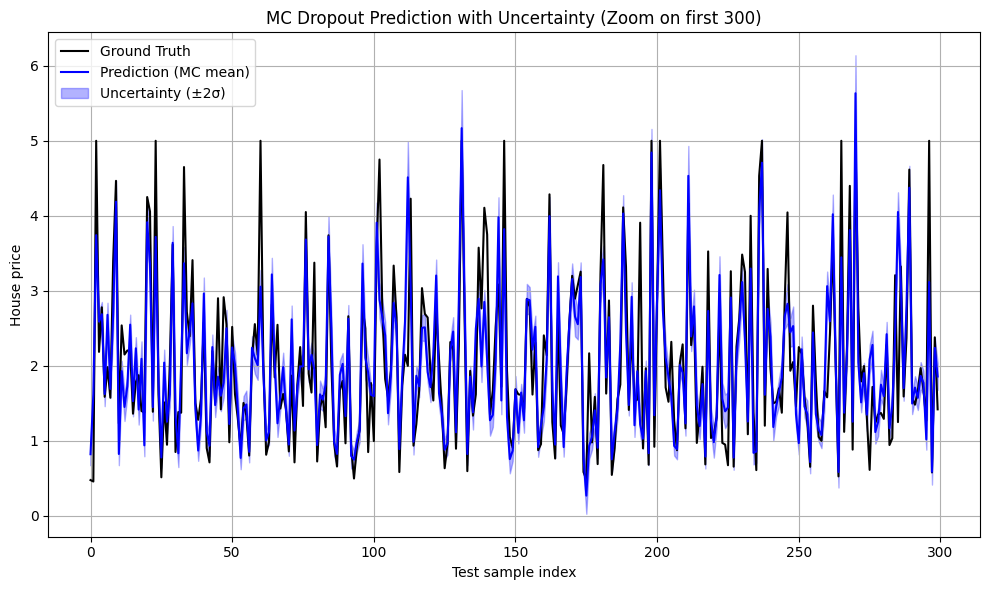

In [ ]:
N = 300

x_axis = np.arange(N)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, true_vals[:N], label="Ground Truth", color='black')
plt.plot(x_axis, mean_preds[:N], label="Prediction (MC mean)", color='blue')
plt.fill_between(
    x_axis,
    mean_preds[:N].flatten() - 2 * std_preds[:N].flatten(),
    mean_preds[:N].flatten() + 2 * std_preds[:N].flatten(),
    color="blue", alpha=0.3, label="Uncertainty (±2σ)"
)
plt.title("MC Dropout Prediction with Uncertainty (Zoom on first 300)")
plt.xlabel("Test sample index")
plt.ylabel("House price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The second plot is a histogram of the predicted standard deviations (σ) from MC Dropout. It gives an overview of how uncertain the model is across the entire test set.

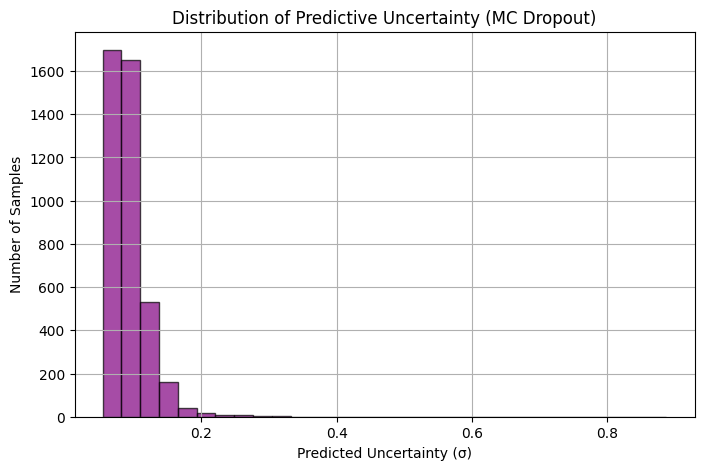

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(std_preds.flatten(), bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel("Predicted Uncertainty (σ)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Predictive Uncertainty (MC Dropout)")
plt.grid(True)
plt.show()


# Experiment 2: Model uncertainty in regression tasks

The aim of this experiment is to demonstrate how MC Dropout captures predictive uncertainty in a regression task. The goal is to compare sevceral models on their predictions and uncertainty estimates on future time step/

We train different models on monthly CO₂ data from Mauna Loa:
- A **standard dropout model** (used in evaluation mode)
- Two **MC Dropout models** (with ReLU and Tanh activations)
- A **Gaussian Process** with an RBF kernel

To compare predictions and uncertainty estimates, we use multiple stochastic forward passes for MC Dropout, so that we can visualize and compare the predictive confidence of each method in regions far from the training data.


## 1. Configuration

We define general parameters for training and load the CO₂ dataset, normalize it and split into training set (75%) and test set (25%).

In [ ]:
# Number of training epochs and Monte Carlo samples
EPOCHS = 1000
MC_SAMPLES = 100

df = pd.read_csv("co2_mm_mlo.csv", comment='#') # Please upload the dataset (csv file) into the colab folder.
X = np.arange(len(df)).reshape(-1, 1).astype(np.float32)
y = df['average'].values.reshape(-1, 1).astype(np.float32)

X_mean, X_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()
X = (X - X_mean) / X_std
y = (y - y_mean) / y_std

# Split into 75% training, 25% testing
split = int(0.75 * len(X))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]



## 2. MC Dropout model

This model is a deep neural network with 4 hidden layers and dropout after each layer. We use two types of activation functions (ReLU or Tanh), which we’ll compare later.

In [ ]:
class MCDropoutNet(nn.Module):
    def __init__(self, dropout_prob=0.1, non_linearity='relu'):
        super().__init__()
        activation = nn.ReLU if non_linearity == 'relu' else nn.Tanh
        self.fc1 = nn.Linear(1, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.act = activation()
    def forward(self, x):
        x = self.act(self.dropout(self.fc1(x)))
        x = self.act(self.dropout(self.fc2(x)))
        x = self.act(self.dropout(self.fc3(x)))
        x = self.act(self.dropout(self.fc4(x)))
        return self.fc5(x)

##3. Train the models

We define a training function, then train three versions of the dropout model:
* Standard dropout (used in evaluation mode, without uncertainty)
* MC Dropout with ReLU activation,
* MC Dropout with Tanh activation.

In [ ]:
def train_model(model, name="model"):
    print(f"Training model '{name}'")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    X_t = torch.from_numpy(X_train)
    y_t = torch.from_numpy(y_train)

    for _ in tqdm(range(EPOCHS), desc=f"Training {name}"):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(model(X_t), y_t)
        loss.backward()
        optimizer.step()

    return model

In [ ]:
device = torch.device('cpu')

model_std  = MCDropoutNet().to(device)
model_relu = MCDropoutNet().to(device)
model_tanh = MCDropoutNet(non_linearity='tanh').to(device)

model_std  = train_model(model_std, 'std')
model_relu = train_model(model_relu, 'mc_relu')
model_tanh = train_model(model_tanh, 'mc_tanh')

Training model 'std'


Training std:   0%|          | 0/1000 [00:00<?, ?it/s]

Training model 'mc_relu'


Training mc_relu:   0%|          | 0/1000 [00:00<?, ?it/s]

Training model 'mc_tanh'


Training mc_tanh:   0%|          | 0/1000 [00:00<?, ?it/s]

We also fit a Gaussian Process regressor with a squared exponential (RBF) kernel to the same training data. The GP provides closed-form predictive mean and uncertainty for comparison with dropout-based methods.

In [ ]:
print("Training Gaussian Process")
gp = GaussianProcessRegressor(kernel=RBF(), alpha=1e-2)
gp.fit(X_train, y_train)

Training Gaussian Process


GaussianProcessRegressor(alpha=0.01, kernel=RBF(length_scale=1))

## 4. Predictions using MC Dropout

Define a function to run `T=100` stochastic forward passes through a dropout model, keeping dropout active. We collect all predictions to compute the empirical predictive mean and standard deviation across samples.

In [ ]:
X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1,1)

def predict_mc(model, X, T=MC_SAMPLES):
    model.train()  # Keep dropout active
    outputs = []
    for _ in tqdm(range(T), desc="MC inference"):
        outputs.append(model(torch.from_numpy(X)).detach().numpy())
    arr = np.array(outputs)
    return arr.mean(0).flatten(), arr.std(0).flatten()

model_std.eval()
y_std = model_std(torch.from_numpy(X_plot)).detach().numpy().flatten()
y_relu, std_relu = predict_mc(model_relu, X_plot)
y_tanh, std_tanh = predict_mc(model_tanh, X_plot)
y_gp, std_gp     = gp.predict(X_plot, return_std=True)

MC inference:   0%|          | 0/100 [00:00<?, ?it/s]

MC inference:   0%|          | 0/100 [00:00<?, ?it/s]

Finally, we plot:
* (a) A standard dropout model (no uncertainty),
* (b) A Gaussian Process baseline (predictive uncertainty),
* (c) MC Dropout model with ReLU,
* (d) MC Dropout model with Tanh.

The red points show training data, the blue curve is the predictive mean, and shaded bands indicate ±2σ standard deviations in the test region. We mark the training/test boundary (dashed blue) and the final time point (dashed red).

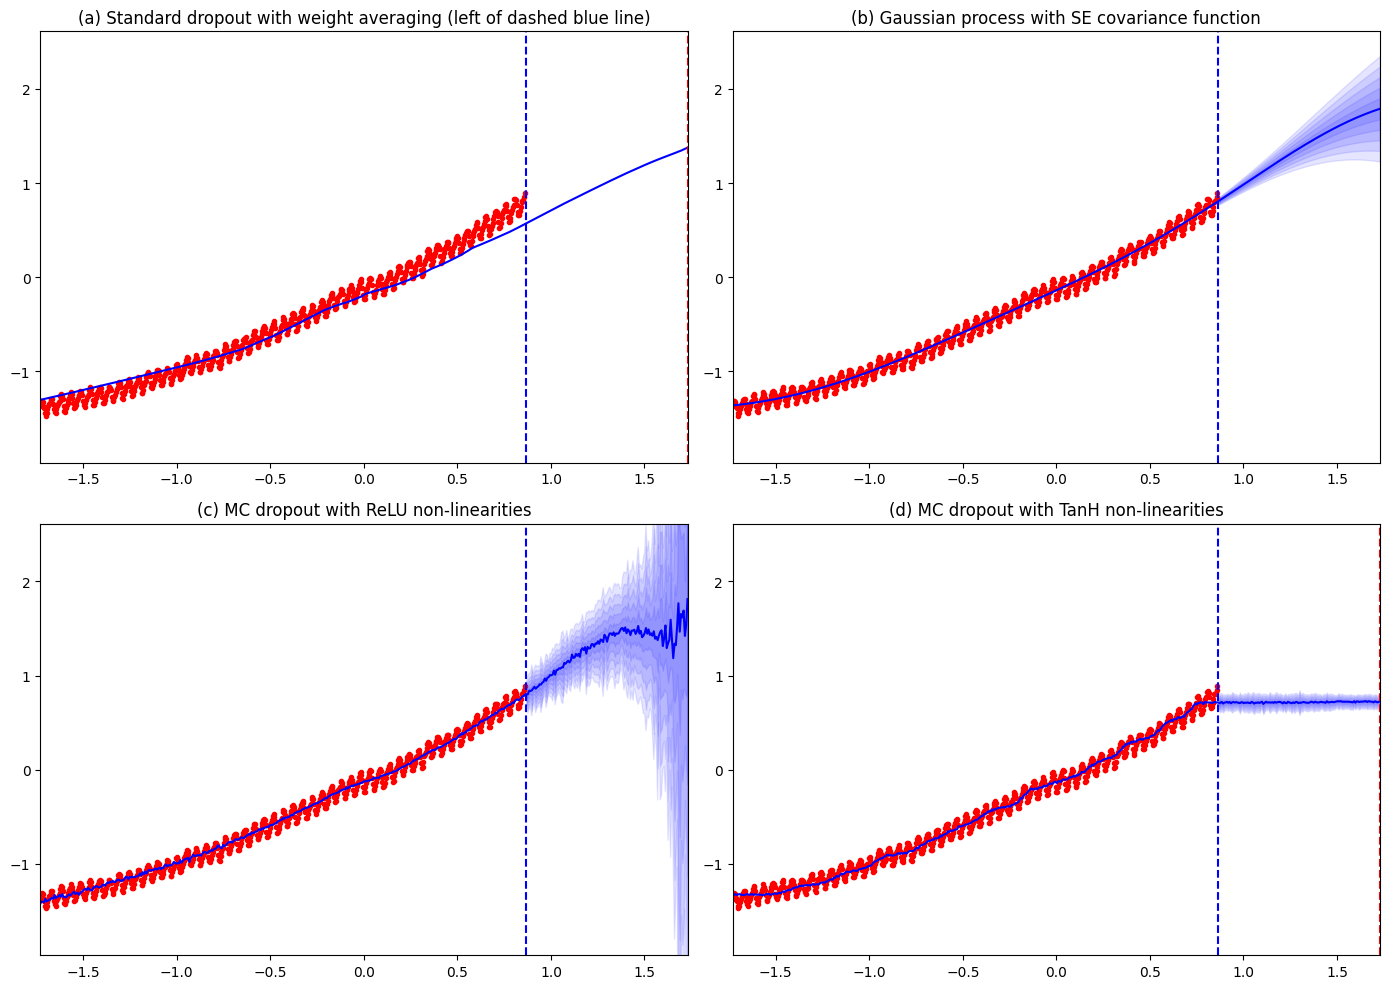

In [ ]:
plt.figure(figsize=(14,10))
x_split_norm = X[split,0]
x_star = X_plot[-1,0]
mask_test = X_plot.flatten() > x_split_norm

# (a) Standard Dropout
plt.subplot(2,2,1)
plt.title("(a) Standard dropout with weight averaging (left of dashed blue line)")
plt.plot(X_train, y_train, 'r.', label='train data')
plt.plot(X_plot, y_std, 'b', label='predictive mean')
plt.axvline(x_split_norm, color='blue', linestyle='--')
plt.axvline(x_star, color='red', linestyle='--')
plt.xlim(X_plot.min(), X_plot.max())
plt.ylim(y.min()-0.5, y.max()+0.5)

# (b) GP RBF
plt.subplot(2,2,2)
plt.title("(b) Gaussian process with SE covariance function")
plt.plot(X_train, y_train, 'r.', label='train data')
plt.plot(X_plot, y_gp, 'b', label='predictive mean')
for i in range(1,6):
    plt.fill_between(X_plot.flatten()[mask_test],
                     (y_gp - 2*std_gp*(i/5))[mask_test],
                     (y_gp + 2*std_gp*(i/5))[mask_test],
                     color='blue', alpha=0.1)
plt.axvline(x_split_norm, color='blue', linestyle='--')
plt.xlim(X_plot.min(), X_plot.max())
plt.ylim(y.min()-0.5, y.max()+0.5)

# (c) MC Dropout ReLU
plt.subplot(2,2,3)
plt.title("(c) MC dropout with ReLU non-linearities")
plt.plot(X_train, y_train, 'r.', label='train data')
plt.plot(X_plot, y_relu, 'b', label='predictive mean')
for i in range(1,6):
    plt.fill_between(X_plot.flatten()[mask_test],
                     (y_relu - 2*std_relu*(i/5))[mask_test],
                     (y_relu + 2*std_relu*(i/5))[mask_test],
                     color='blue', alpha=0.1)
plt.axvline(x_split_norm, color='blue', linestyle='--')
plt.xlim(X_plot.min(), X_plot.max())
plt.ylim(y.min()-0.5, y.max()+0.5)

# (d) MC Dropout TanH
plt.subplot(2,2,4)
plt.title("(d) MC dropout with TanH non-linearities")
plt.plot(X_train, y_train, 'r.', label='train data')
plt.plot(X_plot, y_tanh, 'b', label='predictive mean')
for i in range(1,6):
    plt.fill_between(X_plot.flatten()[mask_test],
                     (y_tanh - 2*std_tanh*(i/5))[mask_test],
                     (y_tanh + 2*std_tanh*(i/5))[mask_test],
                     color='blue', alpha=0.1)
plt.axvline(x_split_norm, color='blue', linestyle='--')
plt.axvline(x_star, color='red', linestyle='--')
plt.xlim(X_plot.min(), X_plot.max())
plt.ylim(y.min()-0.5, y.max()+0.5)

plt.tight_layout()
plt.show()


# Experiment 3 : Model uncertainty in classification tasks

The goal of this experiment is to show how MC Dropout captures uncertainty in classification. By classifying rotated images of the digit "1", we observe how model confidence decreases as rotations make the digit harder to recognize. Multiple stochastic forward passes reveal this uncertainty through varying class probabilities.

## Dataset and training
We start by defining a Le LeNet neural network with tanh non-linearity and dropout.

In [ ]:
class LeNetMC(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 4 * 4, 120)
        self.fc2   = nn.Linear(120, 84)
        self.dropout = nn.Dropout(p)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

We train our model on the MNIST dataset.

In [ ]:
transform = T.ToTensor()
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNetMC(p=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model.train()
epochs = math.ceil(1_000_000 / len(train_loader))
for epoch in range(5):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/5 done.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 47.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.49MB/s]


Epoch 1/5 done.
Epoch 2/5 done.
Epoch 3/5 done.
Epoch 4/5 done.
Epoch 5/5 done.


## Test environment
Once the model trained, we select a digit "1" and generate rotated versions (0° to 180°) to simulate unfamiliar inputs.

In [ ]:
for img, label in train_set:
    if label == 1:
        one_img = img
        break
angles = np.linspace(0, 180, 12)
rotated_images = torch.stack([
    transforms.functional.rotate(one_img, a) for a in angles
]).to(device)


For each rotated image, we perform 100 stochastic forward passes with dropout active to obtain softmax logits and probabilities.
Finally, we plot the predicted values for three classes (1, 5, and 7) across rotations to observe how uncertainty increases as the input becomes harder to classify.

In [ ]:
model.train()  # keep dropout active
T = 500
logits_out   = []
softmax_out  = []

with torch.no_grad():
    for _ in range(T):
        logits = model(rotated_images)
        probs  = F.softmax(logits, dim=1)
        logits_out.append(logits.cpu().numpy())
        softmax_out.append(probs.cpu().numpy())

logits_out  = np.stack(logits_out)
softmax_out = np.stack(softmax_out)

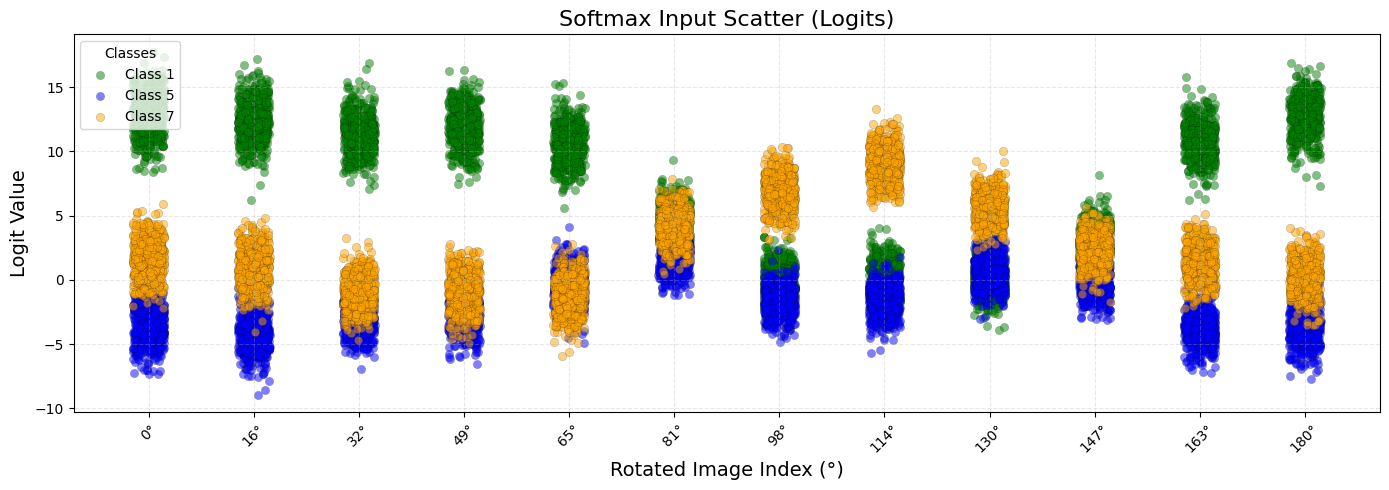

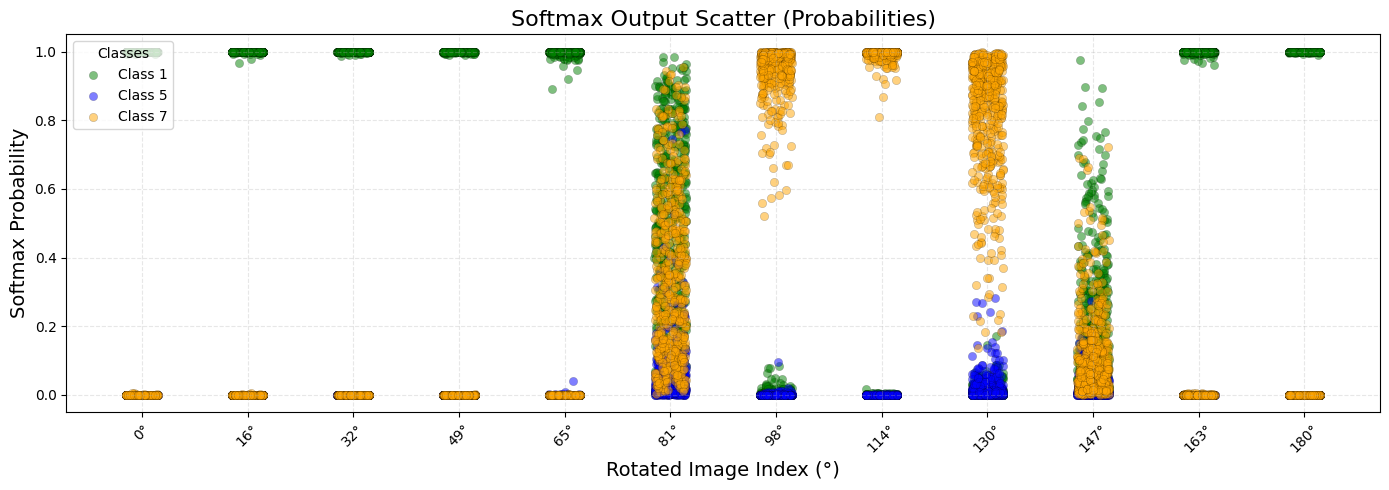

In [ ]:
class_indices   = [1, 5, 7]
class_colors    = {1: 'green', 5: 'blue', 7: 'orange'}
x_jitter_scale  = 0.15
angles_idx      = np.arange(len(angles))

#Softmax input scatter
plt.figure(figsize=(14, 5))
plt.title("Softmax Input Scatter (Logits)", fontsize=16)
plt.xlabel("Rotated Image Index (°)", fontsize=14)
plt.ylabel("Logit Value", fontsize=14)

for img_idx in range(len(angles)):
    for cls in class_indices:
        vals = logits_out[:, img_idx, cls]
        xs   = img_idx + np.random.uniform(-x_jitter_scale, x_jitter_scale, size=T)
        plt.scatter(xs, vals,
                    color=class_colors[cls],
                    alpha=0.5,
                    edgecolors='k',
                    linewidths=0.2,
                    label=f"Class {cls}" if img_idx == 0 else "")

plt.xticks(angles_idx, [f"{int(a)}°" for a in angles], rotation=45)
plt.legend(title="Classes", loc="upper left")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#Softmax output scatter
plt.figure(figsize=(14, 5))
plt.title("Softmax Output Scatter (Probabilities)", fontsize=16)
plt.xlabel("Rotated Image Index (°)", fontsize=14)
plt.ylabel("Softmax Probability", fontsize=14)

for img_idx in range(len(angles)):
    for cls in class_indices:
        vals = softmax_out[:, img_idx, cls]
        xs = img_idx + np.random.uniform(-x_jitter_scale, x_jitter_scale, size=T)
        plt.scatter(xs, vals,
                    color=class_colors[cls],
                    alpha=0.5,
                    edgecolors='k',
                    linewidths=0.2,
                    label=f"Class {cls}" if img_idx == 0 else "")

plt.xticks(angles_idx, [f"{int(a)}°" for a in angles], rotation=45)
plt.legend(title="Classes", loc="upper left")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("figure4B_softmax_scatter_fixed_classes.png", dpi=300)
plt.show()

# Experiment 4 : Model Uncertainty in Reinforcement Learning

The goal of this experiment is to recreate, in a easier setting, the Reinforcement Learning (RL) experience conducted in the paper, that compares MC Dropout-based Thompson sampling against a standard \epsilon-greedy policy.

Instead of replicating the exact same experience as in the paper, that included a 9-eye agent navigating in a 2D environment that contains both positive and negative rewards, we used a much simpler 20-arm Bernoulli bandit experience. This makes it easier for us to implement a RL experiment while preserving the core exploration-vs-exploitation idea and removing all the complexity related to physics and rendering.

## Bandit environment

A simple K-armed Bernoulli bandit: each arm $i$ yields reward 1 with fixed probability $p_i \in [0,1]$.

In [ ]:
class MultiArmedBandit:
    def __init__(self, k=20):
        self.k = k
        self.probs = np.random.uniform(0.0, 1.0, size=k)

    def pull(self, arm):
        prob = self.probs[arm]
        return 1 if np.random.rand() < prob else 0

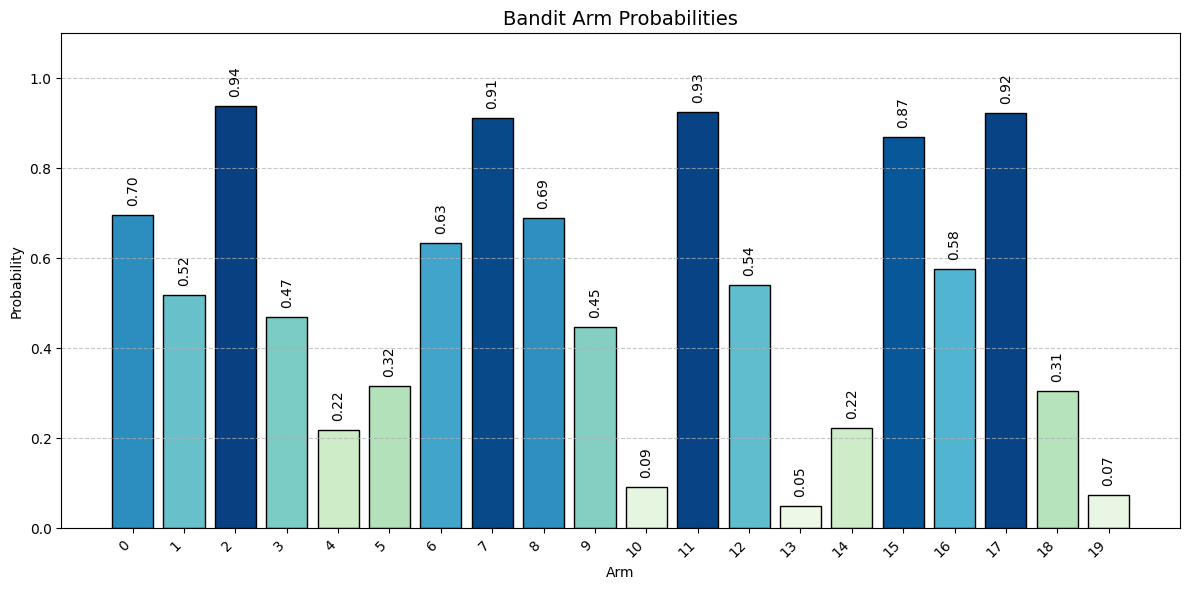

In [ ]:
#Visualization for one example environment

bandit = MultiArmedBandit()
bandit_probs = bandit.probs
k = bandit.k

plt.figure(figsize=(12, 6))
bars = plt.bar(np.arange(k), bandit_probs, color=plt.cm.GnBu(bandit_probs / bandit_probs.max()), edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10, rotation=90)

plt.xticks(np.arange(k), [i for i in range(k)], rotation=45, ha='right')

plt.xlabel("Arm")
plt.ylabel("Probability")
plt.title("Bandit Arm Probabilities", fontsize=14)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## MC‑Dropout value network

We then define a tiny 1-hidden-layer MLP, with dropout, where:

*   The input is the one-hot encoding of the arm;
*   The output is the Bernoulli success probability estimate $\in [0, 1]$.




In [ ]:
class DropoutNetwork(nn.Module):
    def __init__(self, k, hidden_size=16, dropout_p=0.2):
        super().__init__()
        self.fc1 = nn.Linear(k, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x))

## $\epsilon$-greedy policy
For the $\epsilon$-greedy policy, we define a classic exploration rule:  
* With probability $ϵ$ (10 %), pick a random arm.  
* Otherwise, take the arm with the highest predicted reward.  

After each pull, we do a 1-step gradient update so the network slowly learns the true arm probabilities.

In [ ]:
class EpsilonGreedyNNAgent:
    def __init__(self, k=20, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.model = DropoutNetwork(k)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.k)
        with torch.no_grad():
            arms = torch.eye(self.k)
            preds = self.model(arms).squeeze()
            return preds.argmax().item()

    def update(self, arm, reward):
        x = torch.eye(self.k)[arm].unsqueeze(0)
        target = torch.tensor([[reward]], dtype=torch.float)
        pred = self.model(x)
        loss = F.binary_cross_entropy(pred, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Thompson Sampling Agent (with MC Dropout)

We now define the agent to use MC Dropout to perform Thompson Sampling:

* At each decision, we run the network multiple times with dropout enabled to get different predictions.  
* We randomly pick one of these sampled predictions and select the arm with the highest estimated reward.

This allows the agent to naturally balance exploration and exploitation.  
The learning step is the same as $\epsilon$-greedy: we update the network after each action.

In [ ]:
class ThompsonNNAgent:
    def __init__(self, k=20, dropout_samples=20):
        self.k = k
        self.model = DropoutNetwork(k)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.dropout_samples = dropout_samples

    def select_arm(self):
        self.model.train()
        arms = torch.eye(self.k)
        samples = []
        for _ in range(self.dropout_samples):
            preds = self.model(arms).squeeze().detach().numpy()
            samples.append(preds)
        samples = np.stack(samples)
        sampled_values = samples[np.random.randint(0, self.dropout_samples)]
        return np.argmax(sampled_values)

    def update(self, arm, reward):
        x = torch.eye(self.k)[arm].unsqueeze(0)
        target = torch.tensor([[reward]], dtype=torch.float)
        pred = self.model(x)
        loss = F.binary_cross_entropy(pred, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Then, we run one agent for a given number of steps on the same bandit and stores the 0/1 rewards so we can analyse them later.

We repeat the experiment three times to smooth out luck.  
*Both* agents face the **same bandit** so the comparison is fair.  
We average the reward curves across runs.



In [ ]:
def run_experiment(bandit, agent, steps=10000):
    rewards = np.zeros(steps)
    for step in range(steps):
        arm = agent.select_arm()
        reward = bandit.pull(arm)
        agent.update(arm, reward)
        rewards[step] = reward
    return rewards

k = 20
steps = 10000
num_runs = 3

bandit = MultiArmedBandit()  # Shared Bandit
avg_rewards_eps = np.zeros(steps)
avg_rewards_thompson = np.zeros(steps)

for _ in tqdm(range(num_runs), desc="Running experiments"):
    agent_eps = EpsilonGreedyNNAgent(k=k)
    agent_thompson = ThompsonNNAgent(k=k)

    rewards_eps = run_experiment(bandit, agent_eps, steps)
    rewards_thompson = run_experiment(bandit, agent_thompson, steps)

    avg_rewards_eps += rewards_eps
    avg_rewards_thompson += rewards_thompson

avg_rewards_eps /= num_runs
avg_rewards_thompson /= num_runs

Running experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Finally, we plot the comparison of the two methods.

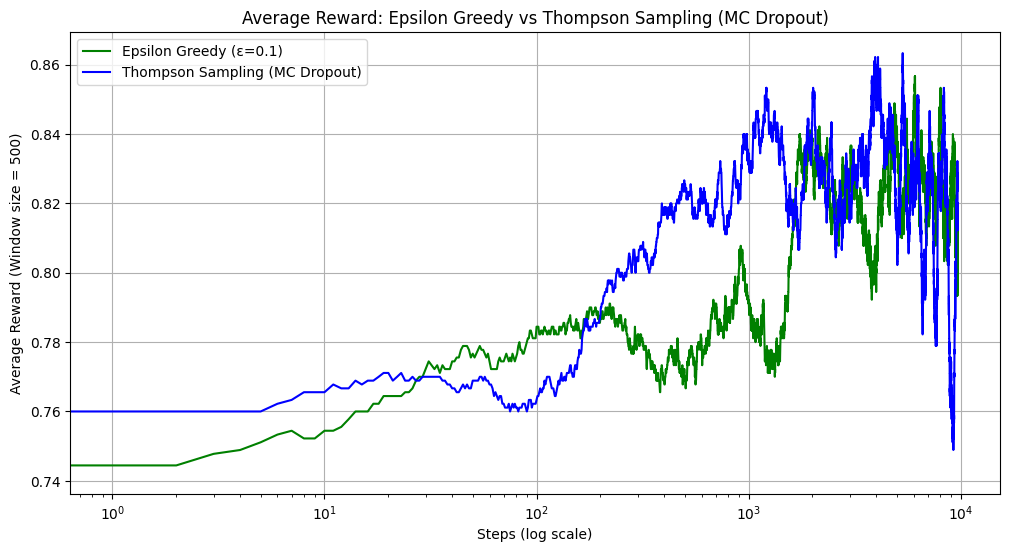

In [ ]:
window = 300
average_eps = np.convolve(avg_rewards_eps, np.ones(window)/window, mode='valid')
average_thompson = np.convolve(avg_rewards_thompson, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(average_eps)), average_eps, label="Epsilon Greedy (ε=0.1)", color='green')
plt.plot(np.arange(len(average_thompson)), average_thompson, label="Thompson Sampling (MC Dropout)", color='blue')
plt.xscale('log')
plt.xlabel("Steps (log scale)")
plt.ylabel("Average Reward (Window size = 500)")
plt.title("Average Reward: Epsilon Greedy vs Thompson Sampling (MC Dropout)")
plt.legend()
plt.grid()
plt.show()